# Topic Modeling

This notebook is a part of the replication package for my ICSE'22 paper.

In this notebook we train and evaluate keyATM, as well as the baseline - LDA. As the training process takes many hours to complete, I will not perform the training again and only provide the code I used for the training when writing the paper. The results of the training I did for the paper are available in pickle format in the `scores` folder.

This notebook contains the following sections:

- **Evaluation Metric**
- **Keyword Generation: Summarization**
- **Model Training and Evaluation**

## Evaluation Metric

Generated topics consist of word probabilities. That is, a topic lists all the words in decreasing probability of occurance in that topic. Typically, topics are evaluated by calculating a certain metric using top-10 most occuring words in a topic.

To conduct the evaluation of the generated topic models, I used **Normalized Pointwise Mutual Information (NPMI)** as the main metric of topic quality and interpretability. According to some experiments, this metric has been found to be closely correlated to human judgement([1](https://cpb-us-e1.wpmucdn.com/sites.uw.edu/dist/2/3760/files/2019/09/Topic-modeling-users-interpretations-of-songs-to-inform-subject-access-in-music-digital-libraries.pdf). [2](https://aclanthology.org/E14-1056/), [3](https://dl.acm.org/doi/10.1145/2684822.2685324)).

Formally, NPMI can be calculated using the following formula:

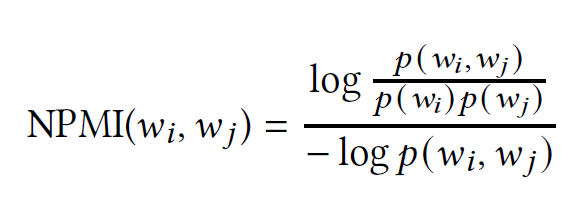

where p(wi,wj) is the number of documents in which words wi and wj appear together, and p(wi)p(wj) is the the number of documents containing wi and wj respectively. The numerator of the NPMI formula is then normalized by dividing it by the negative log-transformed count of wi and wj appearing together. This results in a value between -1 when wi and wj never occur together and 1 when wi and wj only occur together.

The code below is my optimized version of computing NPMI over the intrinsic dataset and extrinsic wikipedia dump.

In [2]:
# next two functions below perform optimized NPMI calculation over intrinsic (corpus)
# and extrinsic (wikipedia) datasets
import math
from itertools import combinations

# keywords is a list of top-10 words
def calculate_npmi_corpus_keywords(keywords):
    keywords_counts = {}
    ret = []
    # generate combinations
    comb = list(combinations(keywords, 2))
        
    for i, (w1, w2) in enumerate(comb):
        if w1 not in keywords_counts:
            keywords_counts[w1] = sum([1 for doc in fin_texts for word in doc if w1 in doc])
        if w2 not in keywords_counts:
            keywords_counts[w2] = sum([1 for doc in fin_texts for word in doc if w2 in doc])
            
        # count both
        p_w1_w2 = sum([1 for doc in fin_texts for word in doc if w1 in doc and w2 in doc])   
        
        if p_w1_w2 == 0: # they never occur together
            res = -1.0
        else:
            p_w1 = keywords_counts[w1]
            p_w2 = keywords_counts[w2]

            p_w1 /= corpus_size
            p_w2 /= corpus_size
            p_w1_w2 /= corpus_size
            num = math.log(p_w1_w2 / (p_w1 * p_w2))
            res = num / -math.log(p_w1_w2)
        ret.append((w1, w2, res))
    return ret

# retrieving occurance information from a sparse matrix is taxing. Therefore, memoing is used
# memoing
keywords_columns = {}
keywords_sums = {}
def calculate_npmi_wiki_keywords(keywords):
    ret = []
    keywords_updated = []
    for keyword in keywords:
        if keyword not in keywords_columns:
            try:
                w_id = wiki_features.index(keyword)
            except:
                continue
            keywords_updated.append(keyword)
            w_arr = wiki_matrix[:,w_id].A.flatten()
            p_w = w_arr.sum()
            keywords_columns[keyword] = w_arr
            keywords_sums[keyword] = p_w
        else:
            keywords_updated.append(keyword)
    # generate combinations
    comb = list(combinations(keywords_updated, 2))
        
    for i, (w1, w2) in enumerate(comb):
        w1_arr = keywords_columns[w1]
        w2_arr = keywords_columns[w2]
        p_w1_w2 = ((w1_arr == 1) & (w1_arr == w2_arr)).sum() 
        
        if p_w1_w2 == 0: # they never occur together
            res = -1.0
        else:
            p_w1 = keywords_sums[w1]
            p_w2 = keywords_sums[w2]

            p_w1 /= wiki_corpus_size
            p_w2 /= wiki_corpus_size
            p_w1_w2 /= wiki_corpus_size
            num = math.log(p_w1_w2 / (p_w1 * p_w2))
            res = num / -math.log(p_w1_w2)
        ret.append((w1, w2, res))
    return ret

## Keyword Generation: Summarization

As described in the paper, I use hybrid tf-idf as my summarization technique to generate sets of keywords. 

In [3]:
# loading the review dataset
import pandas as pd, numpy as np
pd.set_option('display.max_colwidth', None)

data = pd.read_csv('investing.csv')
data = data.drop(columns=['Unnamed: 0'])
data.date = pd.to_datetime(data.date)

# get preprocessed + original reviews for analysis and intrinsic evaluation
fin_texts = [txt.split() for txt in data.loc[(data['for_analysis']) & (data['content_processed'].notnull()), 'content_processed'].values.tolist()]
original_texts = data.loc[(data['for_analysis']) & (data['content_processed'].notnull()), 'content'].values.tolist()
corpus_size = sum([len(doc) for doc in fin_texts])

c:\users\miros\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# train a hybrid tfidf model with a given threshold
# higher thresholds give greater weight to longer texts
# optimal for: investing - 4, food delivery - 6
THRESH = 4

import hybridtfidf

h = hybridtfidf.HybridTfidf(threshold=THRESH)
document_vectors = h.fit_transform(fin_texts)
document_weights = h.transform_to_weights(fin_texts)

In [5]:
# generate top-k summaries
# lower similarity thresh. will produce more distinct seeds
# optimal for: investing - 0.3, food delivery - 0.001
K = 100
SIMILARITY = 0.3

from hybridtfidf import utils
most_significant = utils.select_salient_posts(document_vectors, document_weights, k=K, similarity_threshold=SIMILARITY)

del h
del document_vectors
del document_weights

keywords = [fin_texts[i] for i in most_significant] 
keywords[:5]

[['take', 'money', 'account', 'invest'],
 ['crash', 'time', 'every', 'time'],
 ['day',
  'first',
  'trade',
  'take',
  'stock',
  'list',
  'fee',
  'customer',
  'service'],
 ['lose', 'dollar', 'able', 'log', 'sell', 'stock', 'lose'],
 ['great', 'customer', 'support', 'support']]

As described in the paper, several configurations were tested based on a refined set of keywords. These refined sets were generated by calculating intrinsic NPMI for each keyword and removing the bottom-nth percentile

In [13]:
# for keyATM configurations (keyATM-5, -15, -25)
# thresh defines the lower percentile
# returns new keywords
def remove_low_score(keywords, thresh=5):
    topic_npmis = []
    ret = []
    for keyw_set in keywords:
        new_keyw = []
        npmis = calculate_npmi_corpus_keywords(keyw_set)
        scores = {}
        for w1, w2, score in npmis:
            if w1 not in scores:
                scores[w1] = []
            if w2 not in scores:
                scores[w2] = []
            scores[w1].append(score)
            scores[w2].append(score)
        #return scores
        try:
            scores = {w:np.mean(score) for w, score in scores.items()}
            t = np.percentile(list(scores.values()), thresh)
        except:
            ret.append(keyw_set)
            continue
        for k,v in sorted(scores.items(), key=lambda x: x[1], reverse=True):
            if v < t:
                print(f"REMOVED: {k} {v}")
            else:
                new_keyw.append(k)
            print(k, v)
        ret.append(new_keyw)
    return ret

## Model Training and Evaluation

With that information, we are ready to train and evaluate our models. Unfortunately, the keyATM is only available in R. Therefore, before the training begins, the keyATM R library has to be downloaded and installed from [here](https://cran.r-project.org/web/packages/keyATM/index.html). I use [rpy2](https://rpy2.github.io/) to use R inside of Python. I was able to rewrite and test the bare bones functionality of keyATM in Python, however, the performance was not acceptable for large datasets. Therefore, at this moment, R is preferable. Nevertheless, training for large datasets and large number of topics (e.g., 100) takes a very long time. For example, on my machine, it can take up to 24 hours.

`main_pipeline` below prepares and trains a model for a given set of keywords.

`evaluate_topic_npmi` evaluates a given topic using intrinsic and extrinsic evaluation

In [7]:
import numpy as np
import pandas as pd
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import r, StrVector, ListVector, pandas2ri

#pandas2ri.deactivate()
pandas2ri.activate()

quanteda = importr('quanteda')
keyATM = importr('keyATM')

def evaluate_topic_npmi(keywords):
    topic_npmis = calculate_npmi_wiki_keywords(keywords)
    topic_npmis_corpus = calculate_npmi_corpus_keywords(keywords)

    return np.mean([npmi for _,_, npmi in topic_npmis]), np.mean([npmi for _,_, npmi in topic_npmis_corpus])

def main_pipeline(data, keywords):
    # convert data to keyATM format
    vec = quanteda.tokens(data)
    dfm = quanteda.dfm(vec)
    keyATM_docs = keyATM.keyATM_read(texts=dfm)
    # prepare keywords
    keyATM_keywords = ListVector([("T" + str(i), StrVector(list(set(keyword_set)))) for i,keyword_set in enumerate(keywords)])
    # train
    scores = []
    out = keyATM.keyATM(docs=keyATM_docs, no_keyword_topics=0, keywords=keyATM_keywords, model='base')
    KEY_topic_word = pd.DataFrame(out.rx('phi')[0], columns=out.rx('vocab')[0])
    for i,tname in zip(KEY_topic_word.index, r.colnames(keyATM.top_docs(out))):
        topic_words = KEY_topic_word.iloc[i,:].sort_values(ascending=False).index[:10]
        score_wiki, score_corpus = evaluate_topic_npmi(topic_words)
        scores.append((score_wiki, score_corpus))

    return out, scores

### Baseline: LDA
I use LDA as a baseline for evaluation. For each configuration of keyATM (10,20,...,100) topics the same number of topics is used to train an LDA. The rest of the hyperparameters are set to the same values. Because keyATM without topics functions essentially the same as LDA, **we are able to test if supplementing keyword information to the model significantly improves the performance**.

In [ ]:
# LDA baseline
import gensim.corpora as corpora
import gensim
# Create Dictionary
id2word = corpora.Dictionary(fin_texts)
# Create Corpus
texts = fin_texts
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

lda_scores_npmi_wiki = []
lda_scores_npmi_corpus = []
for i in range(10, 110, 10):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=i, 
                                       chunksize=100,
                                       per_word_topics=True,
                                       iterations=1500)
    LDA_doc_topic = pd.DataFrame([{pair[0]:pair[1] for pair in elem} for elem in lda_model.get_document_topics(corpus)], columns=range(0,16))
    LDA_topic_word = pd.DataFrame(lda_model.get_topics(), columns=[it[1] for it in id2word.items()])
    
    temp_wiki = []
    temp_corpus = []
    for j in LDA_topic_word.index:
        keyw = list(LDA_topic_word.iloc[j,:].sort_values(ascending=False).index[:10])
        score_wiki, score_corpus = evaluate_topic_npmi(keyw)
        temp_wiki.append(score_wiki)
        temp_corpus.append(score_corpus)
    lda_scores_npmi_wiki.append(temp_wiki)
    lda_scores_npmi_corpus.append(temp_corpus)

Finally, the results are saved on the disk using pickle format.

In [ ]:
import pickle
all_scores_npmi_wiki = []
all_scores_npmi_corpus = []
# train keyATM for K={10,20,...,100}
for i in range(10, 20, 100):
    out,scores = main_pipeline(fin_texts, keywords[:i])
    all_scores_npmi_wiki.append([score[0] for score in scores])
    all_scores_npmi_corpus.append([score[1] for score in scores])
    # save on each K
    #with open("scores\\npmi_wiki_0.txt", 'wb') as f:
    #    pickle.dump(all_scores_npmi_wiki, f)
    #with open("scores\\npmi_corpus_0.txt", 'wb') as f:
    #    pickle.dump(all_scores_npmi_corpus, f)

### Case Study: Topic Modeling Investing Domain

To demonstrate my approach, I generate 50 topics for keyATM and 50 topis for LDA. I remove bottom-15th percentile of keywords. These values generate optimal quality topics and were obtained from my paper's results.

In [8]:
# get wikipedia corpus for extrinsic evaluation
wiki_corpus_size = 2531105734 # precomputed
from scipy import sparse
wiki_matrix = sparse.load_npz("C:\\wiki\\wiki_dump_binary_matrix.npz")
with open("C:\\wiki\\features.txt", 'r', encoding='utf-8') as f:
    wiki_features = f.readlines()
wiki_features = [feature.strip() for feature in wiki_features]

In [16]:
# keyATM
n_topics = 50
scores_npmi_wiki = []
scores_npmi_corpus = []
keyw = remove_low_score(keywords[:n_topics], 15)

out,scores = main_pipeline(fin_texts, keyw)
scores_npmi_wiki.append([score[0] for score in scores])
scores_npmi_corpus.append([score[1] for score in scores])

money 0.19673626178226464
take 0.1654257005861073
invest 0.15790666070638423
REMOVED: account 0.1489244742578456
account 0.1489244742578456
time 0.44558554370040554
every 0.22503230597245913
REMOVED: crash 0.07433836017320378
crash 0.07433836017320378
customer 0.15523954265862017
service 0.13486054034646844
day 0.10617663772249827
first 0.10336028782241675
stock 0.09265024313093087
take 0.09089024055073729
trade 0.08015468775626869
REMOVED: fee 0.054232130150116346
fee 0.054232130150116346
REMOVED: list 0.043784061231746205
list 0.043784061231746205
lose 0.2601497179756322
sell 0.16742112589703803
stock 0.1362295556160987
dollar 0.10887018330563054
able 0.0887993987097412
REMOVED: log -0.06591211651919729
log -0.06591211651919729
support 0.4489429864266359
customer 0.23492843076436354
REMOVED: great 0.05610970041204744
great 0.05610970041204744
update 0.2502945345367687
work 0.25013182058569966
last 0.11832717236874808
say 0.0636467227136162
REMOVED: reason 0.05706394346151481
reason 0

open 0.12510913279785887
close 0.09464715920979705
u 0.09164035268340584
give 0.07440200797740122
market 0.07267675969928085
REMOVED: notification 0.052012113519544934
notification 0.052012113519544934
call 0.09953459712386772
people 0.08143553629959814
never 0.07346688712922325
add 0.048008753584073645
REMOVED: soon 0.031788187440787125
soon 0.031788187440787125
actually 0.12310102810578183
bank 0.11479258972659821
idea 0.11258577077796593
simply 0.11048305720835962
give 0.1070774562109178
maybe 0.10696937173924101
sol 0.10667550768484217
one 0.1059869986713551
star 0.10476238645818856
unfortunately 0.104413283156987
problem 0.09971427554617687
attempt 0.09672235106384063
see 0.09522244284831134
worth 0.09329161007517345
information 0.09115590462386855
support 0.08572742884249197
work 0.08260401901408132
invest 0.08084339965678997
download 0.08017772507744213
great 0.07961280187837182
method 0.07279831109693438
guess 0.0701486837179222
REMOVED: back 0.0689571167703974
back 0.068957116

In [32]:
# getting keyatm topics
key_topics = []
KEY_topic_word = pd.DataFrame(out.rx('phi')[0], columns=out.rx('vocab')[0])
for i,tname in zip(KEY_topic_word.index, r.colnames(keyATM.top_docs(out))):
    topic_words = KEY_topic_word.iloc[i,:].sort_values(ascending=False).index[:10]
    key_topics.append((i,topic_words.tolist()))

In [38]:
# selecting 3 topics randomly
import random

example_topics = random.choices(key_topics, k=3)

In [40]:
for i, topic in example_topics:
    print(f"Topic #{i}: {topic}")

Topic #41: ['charge', 'think', 'cancel', 'account', 'thing', 'subscription', 'month', 'money', 'call', 'pending']
Topic #20: ['buy', 'sell', 'stock', 'trade', 'money', 'time', 'anything', 'price', 'day', 'lose']
Topic #26: ['system', 'market', 'good', 'last', 'week', 'trade', 'time', 'day', 'crash', 'money']


Let's try to interpret these topics by printing the top-3 documents for each topic.

In [61]:
print("Topic #41")
for i, idx in enumerate(keyATM.top_docs(out)['42_T41'][:3].tolist()):
    print(f"Review #{i+1}: {original_texts[idx-1]}") # R's indexing starts with 1, not 0

print()
print("Topic #20")
for i, idx in enumerate(keyATM.top_docs(out)['21_T20'][:3].tolist()):
    print(f"Review #{i+1}: {original_texts[idx-1]}")

print()
print("Topic #26")
for i, idx in enumerate(keyATM.top_docs(out)['27_T26'][:3].tolist()):
    print(f"Review #{i+1}: {original_texts[idx-1]}")

Topic #41
Review #1: no idea why it keeps charging me when i have cancelled the subscription months ago
Review #2: Its a faulty app. It keeps charging me when im not even depositing anymoney .
Review #3: They dip into your account even when you havent had or used the app in over 
6 months.

Topic #20
Review #1: Want to execute an order during the day? Not here. Want to lock in gains and sell? Not here. Don’t buy anything on robinhood unless you want to hold it forever.
Review #2: 2 day's I'm not able to see my all money to invest in the app and when I sell my crypto after few minutes I wanted buy again but I didn't access to my money it's ridiculous.
Review #3: Garbage.... 5 or 6 different days on different options I have lost money I could have made... all because the app glitches and won’t allow me to replace orders or sell when I need to

Topic #26
Review #1: Robinhood does not work all the time. You will lose money as it will not let you trade during one of their many lengthy outag

After reading the topic words and reviews, it is clear that **Topic #41** is about extra charges on user accounts, **Topic #20** is about problems with trading stocks during trading time, and **Topic #26** is about market outages and crashes.

As the next step in our case study, let's train an LDA model with 50 topics, keeping the rest of the hyperparameters the same.

In [73]:
import gensim.corpora as corpora
import gensim
# Create Dictionary
id2word = corpora.Dictionary(fin_texts)
# Create Corpus
texts = fin_texts
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

lda_scores_npmi_wiki = []
lda_scores_npmi_corpus = []
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=50, 
                                       chunksize=100,
                                       per_word_topics=True,
                                       iterations=1500)
LDA_doc_topic = pd.DataFrame([{pair[0]:pair[1] for pair in elem} for elem in lda_model.get_document_topics(corpus)], columns=range(0,50))
LDA_topic_word = pd.DataFrame(lda_model.get_topics(), columns=[it[1] for it in id2word.items()])

In [81]:
lda_topics = random.choices(list(range(50)), k=3)

In [83]:
for topic in lda_topics:
    print(f"Topic #{topic+1} words: {LDA_topic_word.iloc[topic].sort_values(ascending=False).index[:10].tolist()}")
    docs = LDA_doc_topic.iloc[:,topic].sort_values(ascending=False)[:3].index.tolist()
    for i,doc in enumerate(docs):
        print(f"Review #{i+1}: {original_texts[doc]}")
    print()

Topic #12 words: ['login', 'time', 'update', 'fix', 'work', 'log', 'please', 'password', 'every', 'new']
Review #1: It’s 2017, there is no reason for an app to not contain basic iPad support and a desktop version; much less having unreliable servers. I could not sign up, then after i finally got past the service interruption error, the app would not link my account. For a company positioning themselves as the new way to invest for the tech savvy millennial, especially as a financial institution that requires a high amount of trust, this is terrible. Down right laughable.
Review #2: I like Acorns platform and idea but I have recurring withdraws setup and it rarely works. I’ve had to resort to doing one time investments when I remember to do it. It’s frustrating. I’ll keep my account for awhile longer but if this isn’t fixed I’ll probably go elsewhere.
Review #3: The app worked great for a week and then it unlinked all my accounts and will not relink them. It keeps telling me there was a

Although **Topic #12** looks interpretable, the reviews #2 and #3 do not seem to correspond to the topic words. **Topic #37** seem to combine several topics in one (e.g., loss of money, fees, and widget). **Topic #3** basically is product of ovefitting and modelled the review #1 really well in the expense of others.

***Outcomes:*** this short case study showed that 3 randomly picked keyATM topics are of better quality that 3 random LDA topics. However, in the next notebook, I will conduct a statistical test to quantitatively assess that difference.